In [178]:
import pandas as pd
import numpy as np
import glob 

import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)

# MTA Entry & Exit Data

In [179]:
# Load in data & format

# http://web.mta.info/developers/turnstile.html
# https://github.com/chriswhong/nycturnstiles

path = '../data/subway_turnstile/turnstile_*.txt'
all_files = glob.glob(path)

df_list = []
for f in all_files: 
    df = pd.read_csv(f)
    df_list.append(df)
turnstile_data = pd.concat(df_list)

geo_encoding_loc = '../data/subway_turnstile/geocoded.csv'
geo_encoding = pd.read_csv(geo_encoding_loc, header=None)

In [180]:
# Clean up turnstile column names
turnstile_data.columns = [c.lower().strip() for c in turnstile_data.columns]
# Clean up geo encoding column names, drop records where coordinates are NaN
geo_encoding.columns = ['c/a', 'unit', 'station', 'linename', 'division', 'latitude', 'longtitude']
geo_encoding.dropna(subset=['latitude', 'longtitude'], inplace=True)

In [181]:
# Only keep the stations where we have coordinate info
turnstile_data = turnstile_data.loc[turnstile_data['c/a'].isin(geo_encoding['c/a'])]

In [182]:
turnstile_data.sort_values(['c/a', 'unit', 'scp', 'date', 'time'], inplace=True)
turnstile_data['period_entry'] = turnstile_data['entries'].diff()
turnstile_data['period_exit'] = turnstile_data['exits'].diff()
mask = turnstile_data.scp != turnstile_data.scp.shift(1)
turnstile_data.loc[mask, 'period_entry'] = np.nan
turnstile_data.loc[mask, 'period_exit'] = np.nan

In [183]:
turnstile_data.dropna(subset=['period_entry', 'period_exit'], inplace=True)
turnstile_data.drop(columns=['entries', 'exits'], inplace=True)
turnstile_data = turnstile_data.loc[turnstile_data['c/a'].isin(geo_encoding['c/a'])]

In [184]:
turnstile_data_grouped = turnstile_data.groupby(['c/a', 'station', 'date', 'time', 'linename', 'division']).agg({'period_entry': 'sum', 
                                                                                        'period_exit': 'sum'
                                                                                       }).reset_index()

In [185]:
turnstile_data_grouped

,c/a,station,date,time,linename,division,period_entry,period_exit
0,R101,SOUTH FERRY,03/23/2019,05:00:00,1RW,IRT,118.0,234.0
1,R101,SOUTH FERRY,03/23/2019,09:00:00,1RW,IRT,919.0,612.0
2,R101,SOUTH FERRY,03/23/2019,13:00:00,1RW,IRT,1745.0,3086.0
3,R101,SOUTH FERRY,03/23/2019,17:00:00,1RW,IRT,3117.0,1799.0
4,R101,SOUTH FERRY,03/23/2019,21:00:00,1RW,IRT,2117.0,1550.0
5,R101,SOUTH FERRY,03/24/2019,01:00:00,1RW,IRT,648.0,813.0
6,R101,SOUTH FERRY,03/24/2019,05:00:00,1RW,IRT,105.0,223.0
7,R101,SOUTH FERRY,03/24/2019,09:00:00,1RW,IRT,557.0,441.0
8,R101,SOUTH FERRY,03/24/2019,13:00:00,1RW,IRT,1472.0,2441.0
9,R101,SOUTH FERRY,03/24/2019,17:00:00,1RW,IRT,2753.0,1866.0


In [186]:
geo_encoding_grouped = geo_encoding.groupby(['c/a']).agg({'latitude': 'first',
                                                         'longtitude': 'first'}).reset_index()

In [187]:
geo_encoding_grouped

,c/a,latitude,longtitude
0,R001,40.703082,-74.012983
1,R002,40.709938,-74.007983
2,R003,40.689945,-73.872564
3,R004,40.691320,-73.867135
4,R005,40.692304,-73.860151
5,R006,40.693866,-73.851568
6,R007,40.695184,-73.844326
7,R008,40.697405,-73.836354
8,R009,40.700536,-73.828382
9,R010,40.757303,-73.989787


In [188]:
turnstile_data_grouped.merge(geo_encoding_grouped, on='c/a')

,c/a,station,date,time,linename,division,period_entry,period_exit,latitude,longtitude
0,R101,SOUTH FERRY,03/23/2019,05:00:00,1RW,IRT,118.0,234.0,40.824787,-73.944232
1,R101,SOUTH FERRY,03/23/2019,09:00:00,1RW,IRT,919.0,612.0,40.824787,-73.944232
2,R101,SOUTH FERRY,03/23/2019,13:00:00,1RW,IRT,1745.0,3086.0,40.824787,-73.944232
3,R101,SOUTH FERRY,03/23/2019,17:00:00,1RW,IRT,3117.0,1799.0,40.824787,-73.944232
4,R101,SOUTH FERRY,03/23/2019,21:00:00,1RW,IRT,2117.0,1550.0,40.824787,-73.944232
5,R101,SOUTH FERRY,03/24/2019,01:00:00,1RW,IRT,648.0,813.0,40.824787,-73.944232
6,R101,SOUTH FERRY,03/24/2019,05:00:00,1RW,IRT,105.0,223.0,40.824787,-73.944232
7,R101,SOUTH FERRY,03/24/2019,09:00:00,1RW,IRT,557.0,441.0,40.824787,-73.944232
8,R101,SOUTH FERRY,03/24/2019,13:00:00,1RW,IRT,1472.0,2441.0,40.824787,-73.944232
9,R101,SOUTH FERRY,03/24/2019,17:00:00,1RW,IRT,2753.0,1866.0,40.824787,-73.944232


In [191]:
turnstile_data_grouped.to_csv(path_or_buf='../data/2019_04_out.csv')

# Mapping MTA Stations

In [151]:
# Data from https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
nyc_shape = gpd.read_file("../data/NYC_Census_Tract/nycb2010.shp")
crs = nyc_shape.crs

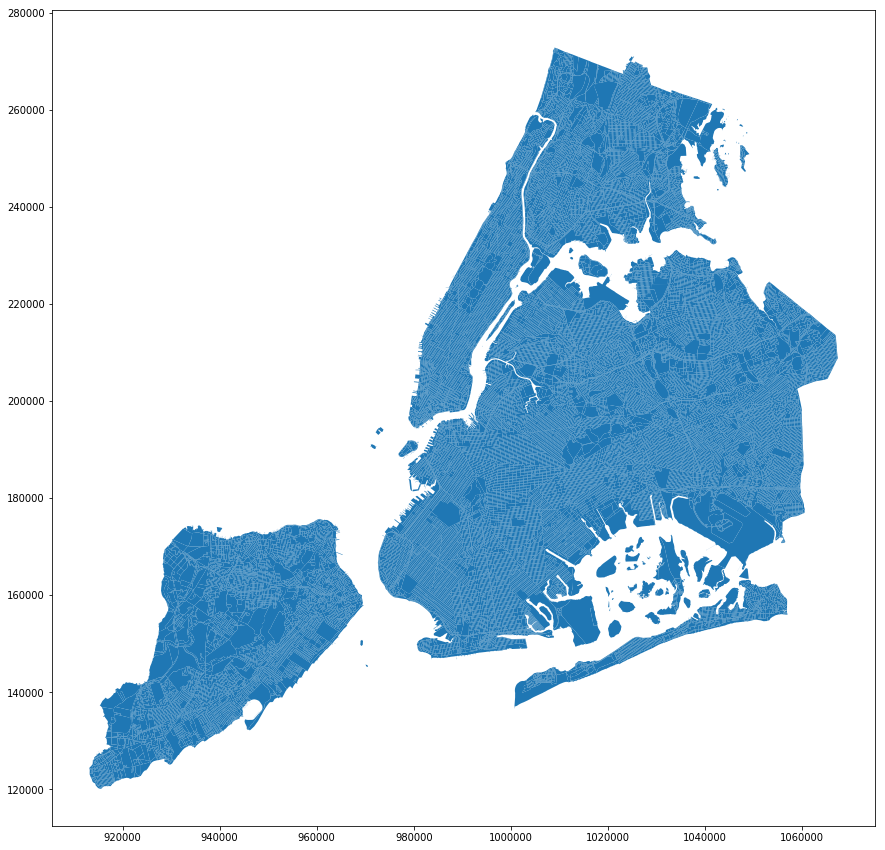

In [147]:
nyc_shape.plot(figsize = (15, 15))

In [153]:
crs

{'init': 'epsg:2263'}

In [167]:
mta_stations = [Point(xy) for xy in zip(geo_encoding_grouped['latitude'], geo_encoding_grouped['longtitude'])]

In [171]:
mta_stations_gdf = gpd.GeoDataFrame(geo_encoding_grouped, crs={'init': 'EPSG:4326'}, geometry=mta_stations)

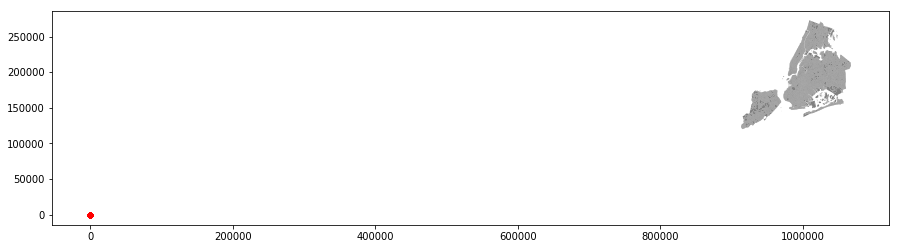

In [172]:
fig, ax = plt.subplots(figsize=(15,15))
nyc_shape.plot(ax=ax, color='grey')
mta_stations_gdf.plot(ax=ax,markersize=20, color='red')

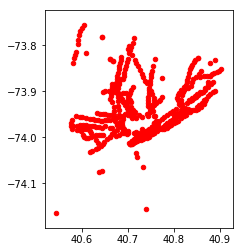

In [174]:
mta_stations_gdf.plot(markersize=20, color='red')